# Static plotting for `spatialdata` 

In this notebook, we will explore how to use `spatialdata-plot` to generate static plots of various different technologies. When we load the `spatialdata-plot` library, this adds the `.pl` accessor to every `SpatialData` object, which gives us access to the plotting functions. Their logic is loosly inspired by the ggplot-library in R, in which one can chain multiple function calls, gradually building the final figure.

In [1]:
%load_ext jupyter_black

In [61]:
import spatialdata as sd
import spatialdata_plot as sdp
import matplotlib.pyplot as plt  # for multi-panel plots later
import scanpy as sc
import squidpy as sq

for p in [sd, sdp, sc, sq]:
    print(f"{p.__name__}: {p.__version__}")

sdata_visium = sd.read_zarr("../data/visium.zarr/")

spatialdata: 0.2.2
spatialdata_plot: 0.2.5
scanpy: 1.10.2
squidpy: 1.2.2


In particular, the library exposes the following funcitons:
- [`Spatialdata.pl.render_images()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_images)
- [`Spatialdata.pl.render_labels()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_labels)
- [`Spatialdata.pl.render_points()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_points)
- [`Spatialdata.pl.render_shapes()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_shapes)
- [`Spatialdata.pl.show()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.show)

We can chain the 4 `render_xxx` functions to gradually build up a figure, with a final call to `show` to then actually render out the function. In the following sections we will explore these functions further.


## Overview
- [Simple function calls](#simple-viz)
- [Stacking function calls](#stacked-viz)
- [Transformations](#transformations)
- [Best practises](#best-practises)

## Simple function calls <a id="simple-viz"></a>
Let's first focus on the [MERFISH](https://vizgen.com/technology/) data from the previous notebook. As we can see below, it contains slots for `Images`, `Points`, `Shapes`, and `Tables`.

In [62]:
sdata_visium

SpatialData object, with associated Zarr store: /Users/tim.treis/Documents/GitHub/spatialdata-workshops/data/visium.zarr
├── Images
│     ├── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image': DataArray[cyx] (3, 2000, 1744)
│     └── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image': DataArray[cyx] (3, 600, 523)
├── Shapes
│     └── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma': GeoDataFrame shape: (5756, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (5756, 18085)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma (Shapes)
    ▸ 'downscaled_lowres', with elements:
        CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma (Shapes)
    ▸ 'global', with elements:
        CytAssist_FFPE_Protein_Expression_Human_Gl

Let's first visualise the individual contained modalities separately. 

INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              
INFO     Rasterizing image for faster rendering.                                                                   


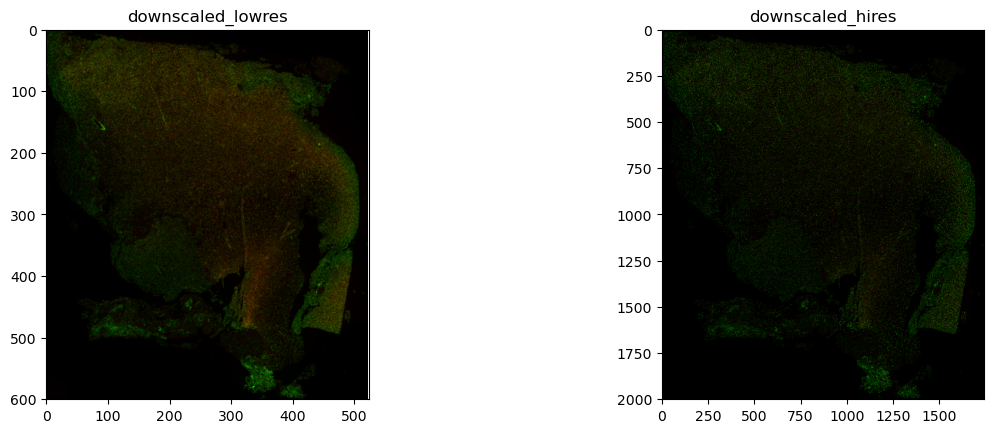

In [63]:
sdata_visium.pl.render_images().pl.show()

INFO     Rasterizing image for faster rendering.                                                                   


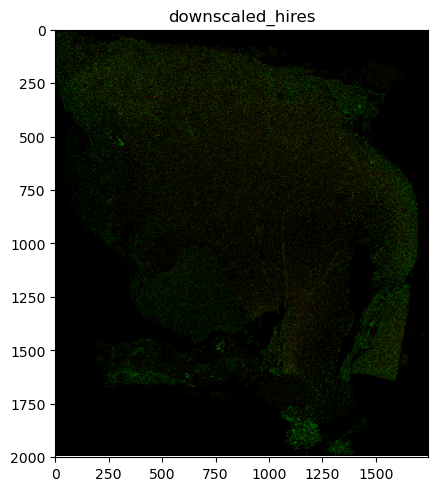

In [64]:
sdata_visium.pl.render_images().pl.show("downscaled_hires")

INFO     Rasterizing image for faster rendering.                                                                   


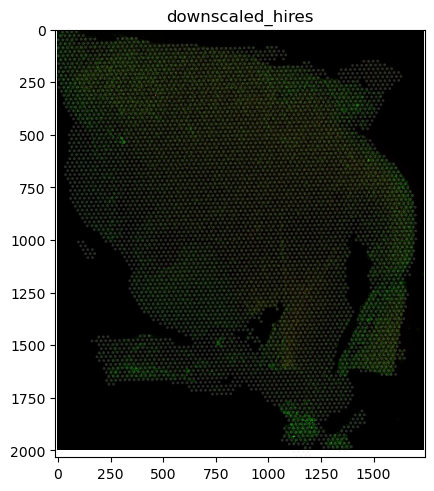

In [65]:
(
    sdata_visium.pl.render_images()
    .pl.render_shapes(fill_alpha=0.2)
    .pl.show("downscaled_hires")
)

## Identify some genes with spatial patterns

In [66]:
adata_visium = sdata_visium.table

sq.gr.spatial_neighbors(adata_visium)
sq.gr.spatial_autocorr(
    adata_visium,
    mode="moran",
    genes=adata_visium.var_names,
    n_perms=10,
    n_jobs=1,
)
adata_visium.uns["moranI"].head(10)

/var/folders/qg/qgc908995g3fc8qtss2fsbhhxyxxj4/T/ipykernel_88991/864616188.py:1: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  adata_visium = sdata_visium.table
/Users/tim.treis/anaconda3/envs/spatialdata-workshop/lib/python3.11/site-packages/scanpy/metrics/_common.py:62: UserWarning: 43 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?/s]

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
CST3,0.925848,0.0,0.000061,0.0,0.090909,0.000099,NaN,NaN,0.10556
GFAP,0.907449,0.0,0.000061,0.0,0.090909,0.000092,NaN,NaN,0.10556
IFI6,0.903449,0.0,0.000061,0.0,0.090909,0.000125,NaN,NaN,0.10556
PTPRZ1,0.901717,0.0,0.000061,0.0,0.090909,0.000093,NaN,NaN,0.10556
SPARC,0.900480,0.0,0.000061,0.0,0.090909,0.000104,NaN,NaN,0.10556
APOE,0.899052,0.0,0.000061,0.0,0.090909,0.000043,NaN,NaN,0.10556
B2M,0.897966,0.0,0.000061,0.0,0.090909,0.000067,NaN,NaN,0.10556
CPE,0.895360,0.0,0.000061,0.0,0.090909,0.000101,NaN,NaN,0.10556
PTN,0.891295,0.0,0.000061,0.0,0.090909,0.000093,NaN,NaN,0.10556
CTSB,0.889973,0.0,0.000061,0.0,0.090909,0.000069,NaN,NaN,0.10556


INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


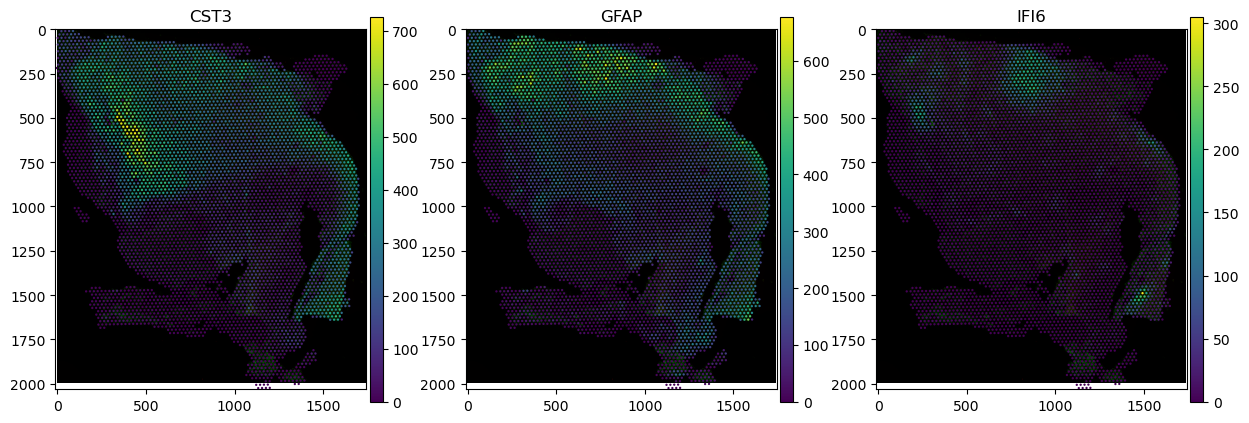

In [70]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for idx, gene in enumerate(["CST3", "GFAP", "IFI6"]):
    (
        sdata_visium.pl.render_images()
        .pl.render_shapes(color=f"{gene}")
        .pl.show("downscaled_hires", ax=axs[idx], title=gene)
    )

Generally, the `spatialdata-plot` library tries to be as flexible as possible, allowing for a wide range of different plotting options. However, this flexibility comes at the cost of some complexity. To limit the amount of permutations we have to account for in the codebase, we recommend a workflow in which one gradually build up a figure on an `ax` object. If multiple similar plots are required, it is currently the easiest way, to manually assign them to their panels, for example like this:

## Other technologies

In [73]:
sdata_visium_hd = sd.read_zarr("../data/visium_hd.zarr")
sdata_visium_hd

/Users/tim.treis/anaconda3/envs/spatialdata-workshop/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SpatialData object, with associated Zarr store: /Users/tim.treis/Documents/GitHub/spatialdata-workshops/data/visium_hd.zarr
├── Images
│     ├── 'Visium_HD_Mouse_Small_Intestine_hires_image': DataArray[cyx] (3, 5575, 6000)
│     └── 'Visium_HD_Mouse_Small_Intestine_lowres_image': DataArray[cyx] (3, 558, 600)
├── Shapes
│     └── 'Visium_HD_Mouse_Small_Intestine_square_008um': GeoDataFrame shape: (351817, 1) (2D shapes)
└── Tables
      └── 'square_008um': AnnData (351817, 19059)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        Visium_HD_Mouse_Small_Intestine_hires_image (Images), Visium_HD_Mouse_Small_Intestine_square_008um (Shapes)
    ▸ 'downscaled_lowres', with elements:
        Visium_HD_Mouse_Small_Intestine_lowres_image (Images), Visium_HD_Mouse_Small_Intestine_square_008um (Shapes)
    ▸ 'global', with elements:
        Visium_HD_Mouse_Small_Intestine_square_008um (Shapes)

In [95]:
sdata_visium_hd.tables["square_008um"].var_names_make_unique()

INFO     Rasterizing image for faster rendering.                                                                   


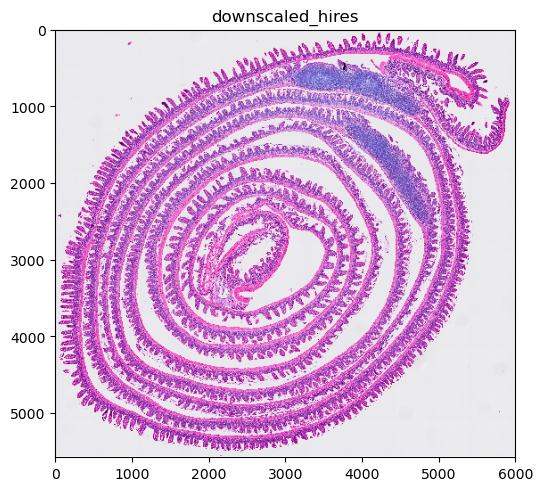

In [80]:
sdata_visium_hd.pl.render_images().pl.show("downscaled_hires")

In [96]:
sdata_visium_hd_crop = sdata_visium_hd.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[4500, 0],
    max_coordinate=[6000, 1500],
    target_coordinate_system="downscaled_hires",
)

In [111]:
sdata_visium_hd_crop.tables["square_008um"].to_df().apply(
    lambda col: col.var(), axis=0
).sort_values()

Ptpn20           0.000000
Olfr718-ps1      0.000000
Spdye4b          0.000000
Zfp853           0.000000
Pou6f2           0.000000
                  ...    
Iglc1           45.842403
Lyz1            50.397385
Defa21          58.193329
Igha           189.171158
Igkc           215.507874
Length: 19059, dtype: float32

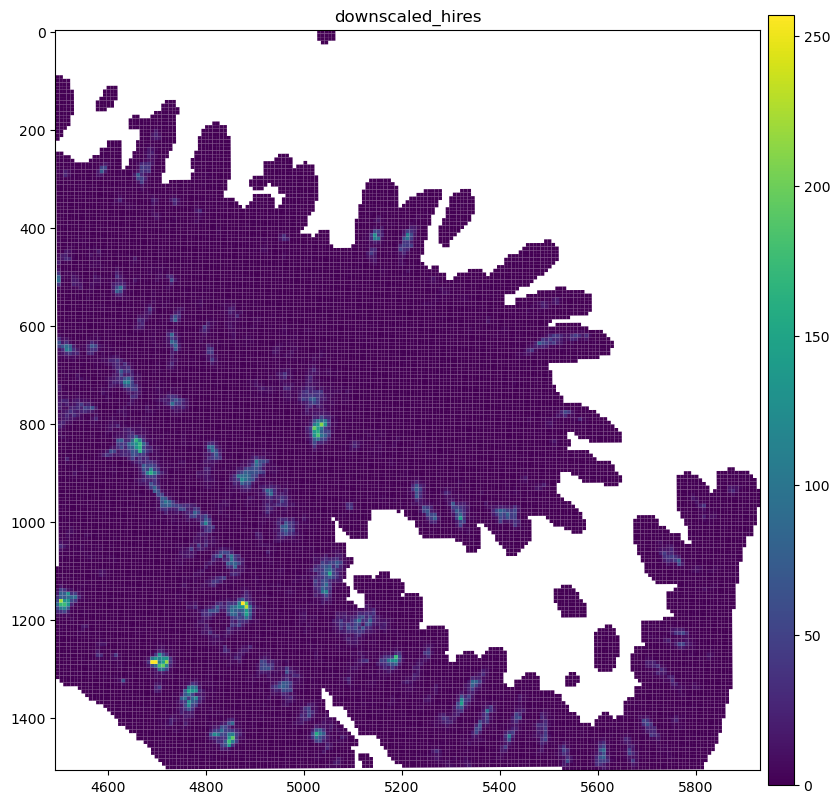

In [102]:
fix, axs = plt.subplots(1, 1, figsize=(10, 10))
sdata_visium_hd_crop.pl.render_shapes(color="Igha", method="matplotlib").pl.show(
    "downscaled_hires", ax=axs
)

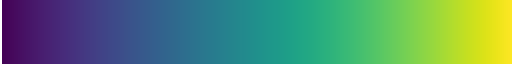

In [109]:
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent

cmap = set_zero_in_cmap_to_transparent(plt.cm.viridis)
cmap

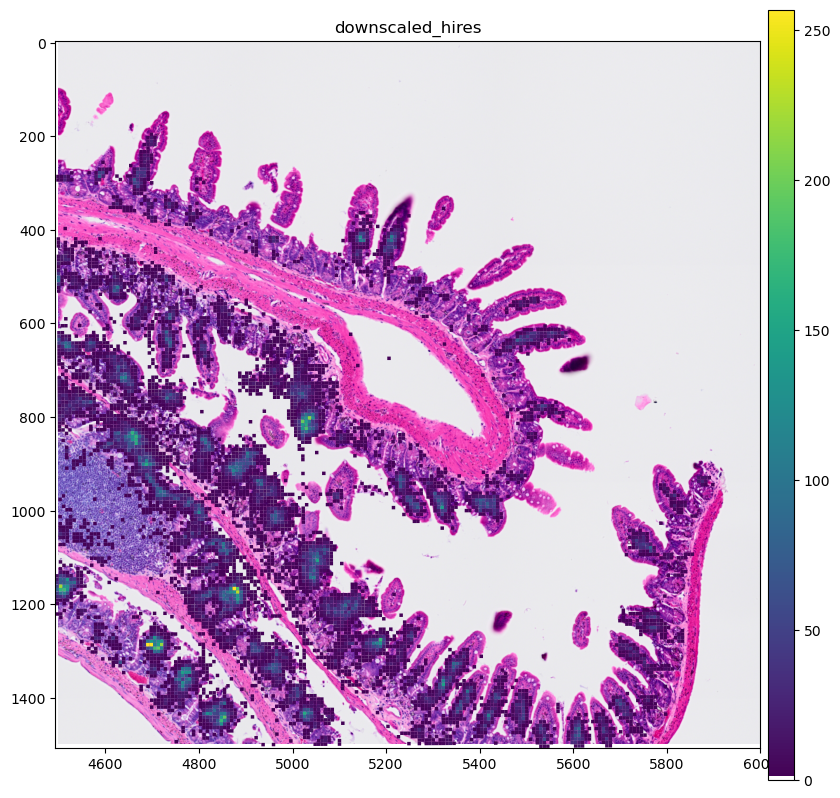

In [110]:
fix, axs = plt.subplots(1, 1, figsize=(10, 10))
sdata_visium_hd_crop.pl.render_images().pl.render_shapes(
    color="Igha", method="matplotlib", cmap=cmap
).pl.show("downscaled_hires", ax=axs)

In [112]:
sdata_xenium = sd.read_zarr("../data/xenium.zarr")
sdata_xenium

/Users/tim.treis/anaconda3/envs/spatialdata-workshop/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SpatialData object, with associated Zarr store: /Users/tim.treis/Documents/GitHub/spatialdata-workshops/data/xenium.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 5636, 1448), (3, 2818, 724), (3, 1409, 362), (3, 704, 181), (3, 352, 90)
│     └── 'morphology_focus': DataTree[cyx] (1, 17098, 51187), (1, 8549, 25593), (1, 4274, 12796), (1, 2137, 6398), (1, 1068, 3199)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
│     └── 'nucleus_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (162254, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (162254, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (156628, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (162254, 377)
with coordinate sys